# Исследование поведения пользователей мобильного приложения

Перед нами стоит задача изучить поведение пользователей мобильного приложения сервиса «Ненужные вещи» и выявить закономерности, которые помогут понять, как пользователи взаимодействуют с продуктом.

Для этого будет проведён анализ ключевых метрик:

- Retention Rate – насколько пользователи возвращаются в приложение после первого использования.
- Время в приложении – сколько времени пользователи проводят внутри сервиса.
- Частота действий – как активно пользователи совершают события.
- Конверсия в целевое действие – доля пользователей, которые просматривают контакты.

**Основные этапы исследования**

1. Исследовательский анализ данных: изучение ключевых метрик, выявление закономерностей и возможных аномалий.
2. Сегментация пользователей: разбиение аудитории на группы по паттернам поведения.
3. Проверка статистических гипотез: Отличается ли конверсия в просмотры контактов у пользователей, пришедших из Yandex и Google? Влияет ли взаимодействие с рекомендациями на конверсию?

**Ожидаемые результаты**
По итогам исследования удастся выделить группы пользователей с различными моделями поведения, выявить потенциальные точки роста продукта и сформулировать рекомендации по повышению удержания и вовлечённости пользователей.

##Знакомство с данными

Для начала работы импортируем необходимые библиотеки и загрузим файлы:

In [ ]:
#импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from statsmodels.stats.proportion import proportions_ztest
import math
import warnings

In [ ]:
#скроем лишние предупреждения
warnings.filterwarnings("ignore")

#настройки Pandas для вывода всех столбцов
pd.set_option("display.max_columns", None)

#установка максимального количества строк для отображения
pd.set_option(
    "display.max_rows", 50)

pd.set_option(
    "display.max_colwidth", 100)

#установка ширины дисплея
pd.set_option(
    "display.width", 1000
)

In [ ]:
#загружаем файл с событиями, вариант для локальной версии и для jupiter
try:
    events_log = pd.read_csv('mobile_dataset.csv')
except:
    events_log = pd.read_csv('/datasets/mobile_dataset.csv')

In [ ]:
events_log.head(10)

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
5,2019-10-07 00:01:19.993624,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
6,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
7,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
8,2019-10-07 00:01:49.732803,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
9,2019-10-07 00:01:54.958298,advert_open,020292ab-89bc-4156-9acf-68bc2783f894


В первом датасете у нас содержаттся данные о совершенных пользователями действиях. Для каждого события указано его наименование, время совершения и идентификатор пользователя.

Просмотрим общую информацию о датафрейме:

In [ ]:
events_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
#загружаем файл с источниками, вариант для локальной версии и для jupiter
try:
    users_sources = pd.read_csv('mobile_sourсes.csv')
except:
    users_sources = pd.read_csv('/datasets/mobile_sourсes.csv')

In [ ]:
users_sources.head(10)

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google
5,17f6b2db-2964-4d11-89d8-7e38d2cb4750,yandex
6,62aa104f-592d-4ccb-8226-2ba0e719ded5,yandex
7,57321726-5d66-4d51-84f4-c797c35dcf2b,google
8,c2cf55c0-95f7-4269-896c-931d14deaab5,google
9,48e614d6-fe03-40f7-bf9e-4c4f61c19f64,yandex


В этом датасете можно найти информацию об источнике, с которого каждый из пользователь установил приложения. Также просмотрим его общую информацию:

In [ ]:
users_sources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Знакомство с данными прошло успешно, далее будем использовать полученную информацию в процессе предобработки.

## Предобработка даных

Перед анализом необходимо подготовить данные: привести их к удобному для работы формату, обработать пропуски и удалить возможные аномалии. Это важно, чтобы расчёты метрик и последующие выводы были корректными.

В первую очередь переименуем столбцы и приведем их к единому виду:

In [ ]:
events_log.rename(columns={'event.time': 'event_time',
                            'event.name': 'event_name',
                            'user.id': 'user_id'}, inplace=True)

In [ ]:
users_sources.rename(columns={'userId': 'user_id'}, inplace=True)

Изменим тип столбца со временем на стандартный datetime:

In [ ]:
events_log['event_time'] = pd.to_datetime(events_log['event_time'])

Для лучшего понимания данных найдем весь промежуток, в течение которого были записаны логи событий:

In [ ]:
events_log['event_time'].min(), events_log['event_time'].max()

(Timestamp('2019-10-07 00:00:00.431357'),
 Timestamp('2019-11-03 23:58:12.532487'))

Запомним информацию, что у нас хранятся данные с 7 октября по 3 ноября 2019 года, далее нам она понадобится для когортного анализа.

Далее переходим к анализу пропусков и дубликатов, найдем их количество в каждом из датафреймов:

In [ ]:
events_log.isna().sum()

,0
event_time,0
event_name,0
user_id,0


In [ ]:
users_sources.isna().sum()

,0
user_id,0
source,0


In [ ]:
events_log.duplicated().sum()

0

In [ ]:
users_sources.duplicated().sum()

0

Дубликатов и пропусков нет, найдем какое количество уникальных пользователей логировали данные и посмотрим совпадают ли значения:

In [ ]:
events_log['user_id'].nunique()

4293

In [ ]:
users_sources['user_id'].nunique()

4293

В обоих датафреймах хранится информация о 4293 пользователях.

Посмотрим на распределение пользователей в зависимости от источников данных:

In [ ]:
users_sources['source'].value_counts()

,count
source,
yandex,1934
other,1230
google,1129


Далее посмотрим все типы событий и как распределены логи между ними:

In [ ]:
events_log['event_name'].value_counts()

,count
event_name,
tips_show,40055
photos_show,10012
advert_open,6164
contacts_show,4450
map,3881
search_1,3506
favorites_add,1417
search_5,1049
tips_click,814


В получившейся таблице мы видим два типа события contacts_show и show_contacts. Скорее всего была допущена ошибка в данных и одно и тоже событие стало записываться по-разному. Исправим эту ошибку:

In [ ]:
events_log['event_name'] = events_log['event_name'].replace({'show_contacts': 'contacts_show'})

Для удобства анализа объединим все виды поисковых действий в одно общее событие. У нас нет информации о том, чем они различаются, поэтому их разделение не имеет практического смысла:

In [ ]:
events_log['event_name'] = events_log['event_name'].replace({
    'search_1': 'search', 'search_2': 'search', 'search_3': 'search',
    'search_4': 'search', 'search_5': 'search', 'search_6': 'search',
    'search_7': 'search'
})

В ходе предобработки данных мы привели столбцы к единому формату, скорректировали их названия и убедились в отсутствии явных дубликатов и пропусков. Дополнительно мы обнаружили и исправили неявные дубликаты в наименованиях событий, что помогло избежать ошибок в дальнейшем анализе. Также были определены границы временного диапазона данных и проверено количество уникальных пользователей, что позволит точнее интерпретировать результаты исследования.

## Исследовательский анализ

Исследовательский анализ данных позволит выявить ключевые особенности поведения пользователей. Мы изучим, как долго пользователи остаются в приложении, насколько активно совершают действия и как часто достигают целевого события — просмотра контактов. Эти данные помогут не только понять общие тенденции, но и определить возможные проблемы, которые снижают вовлечённость и конверсию. Кроме того, результаты анализа станут основой для дальнейшей сегментации и проверки гипотез.

### Анализ Retention rate

Анализ Retention Rate поможет понять, как долго пользователи остаются активными после первого взаимодействия с приложением. Это ключевой показатель, который отражает, насколько продукт удерживает аудиторию. Если удержание низкое, это может свидетельствовать о проблемах с удобством использования или ценностью сервиса. В ходе анализа мы выявим динамику возврата пользователей в рамках когорт

Для удобства работы с данными округлим время события до секунды:

In [ ]:
#округляем до секунд
events_log['event_time'] = events_log['event_time'].dt.floor('S')

Создадим профили пользователей, в которых укажем время и наименование первого события для них:

In [ ]:
#создаем профили
profiles = (events_log.sort_values(by=['user_id', 'event_time'])
  .groupby('user_id')
  .agg({
    'event_time': 'first',
    'event_name': 'first'
  })).reset_index()

In [ ]:
profiles.head()

,user_id,event_time,event_name
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,tips_show
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33,search
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,photos_show
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05,search
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,contacts_show


Отдельно выделим дату первого события. В зависимости от даты пользователей далее разделим на когорты:

In [ ]:
profiles['cohort_date'] = profiles['event_time'].dt.date

In [ ]:
#объединяем таблицу событий с профилями
events_log = events_log.merge(profiles[['user_id', 'cohort_date']], on='user_id', how='left')

In [ ]:
events_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_time   74197 non-null  datetime64[ns]
 1   event_name   74197 non-null  object        
 2   user_id      74197 non-null  object        
 3   cohort_date  74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


In [ ]:
#приводим к нужному виду
events_log['cohort_date'] = pd.to_datetime(events_log['cohort_date'])

Вычислим лайфтайм каждого из событий:

In [ ]:
events_log['lifetime'] = (events_log['event_time'] - events_log['cohort_date']).dt.days

Смотрим полученную таблицу с событиями:

In [ ]:
events_log.head()

,event_time,event_name,user_id,cohort_date,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0


Сгруппируем всем пользователей по когортам дня их первого использования мобильного приложения. В каждый из последующих дней найдем количество вернувшихся пользователей.

In [ ]:
cohort_counts = events_log.pivot_table(
    index=['cohort_date'],
    columns=['lifetime'],
    values='user_id',
    aggfunc='nunique'
)

Далее построим сводную таблицу удержания в процентах в каждый из дней:

In [ ]:
#делим данные таблицы удержания на размеры когорт
retention_rate = cohort_counts.div(cohort_counts[0], axis=0) * 100
retention_rate = retention_rate.round(2)
retention_rate

lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
cohort_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-10-07,100.0,18.14,10.29,10.78,6.86,5.88,3.92,7.84,6.37,4.90,6.86,3.92,1.96,3.92,5.88,4.41,5.39,3.92,2.94,3.92,0.98,1.96,3.92,2.94,1.96,4.90,1.96,1.47
2019-10-08,100.0,17.96,11.98,10.18,3.59,3.59,6.59,4.79,6.59,5.39,5.99,4.19,1.80,4.79,2.99,3.59,2.99,3.59,1.20,3.59,4.79,1.80,2.40,3.59,2.99,2.99,2.99,NaN
2019-10-09,100.0,9.66,8.52,5.68,5.68,7.95,5.68,5.68,5.68,5.11,2.27,2.27,3.98,3.98,4.55,2.27,2.27,1.14,1.14,2.84,1.70,1.14,2.84,0.57,1.70,2.84,NaN,NaN
2019-10-10,100.0,13.79,7.47,10.34,7.47,9.20,6.32,7.47,6.32,5.75,4.02,4.60,4.60,6.32,2.30,4.02,3.45,6.90,4.02,2.87,1.72,3.45,2.30,1.72,1.72,NaN,NaN,NaN
2019-10-11,100.0,8.82,8.09,13.24,9.56,6.62,5.88,7.35,2.21,NaN,5.15,3.68,4.41,4.41,3.68,2.21,3.68,6.62,3.68,2.94,2.94,2.94,2.21,2.21,NaN,NaN,NaN,NaN
2019-10-12,100.0,20.00,12.00,10.40,6.40,7.20,10.40,8.00,7.20,6.40,6.40,5.60,4.80,6.40,4.00,7.20,1.60,4.80,4.00,3.20,1.60,5.60,5.60,NaN,NaN,NaN,NaN,NaN
2019-10-13,100.0,17.57,8.78,5.41,7.43,6.08,4.05,8.11,4.73,6.08,1.35,4.05,2.03,6.08,4.73,4.05,0.68,NaN,2.70,2.03,0.68,3.38,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-14,100.0,16.76,9.19,9.73,10.27,7.03,5.41,5.41,5.41,5.41,3.78,2.70,3.78,3.78,3.78,3.24,4.86,5.41,2.70,0.54,2.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,100.0,15.05,10.22,9.14,5.91,5.38,6.45,6.99,8.60,3.23,4.30,2.15,2.69,3.76,3.23,4.84,2.69,3.76,2.69,2.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Визуализируем полученную таблицу, построив тепловую карту:

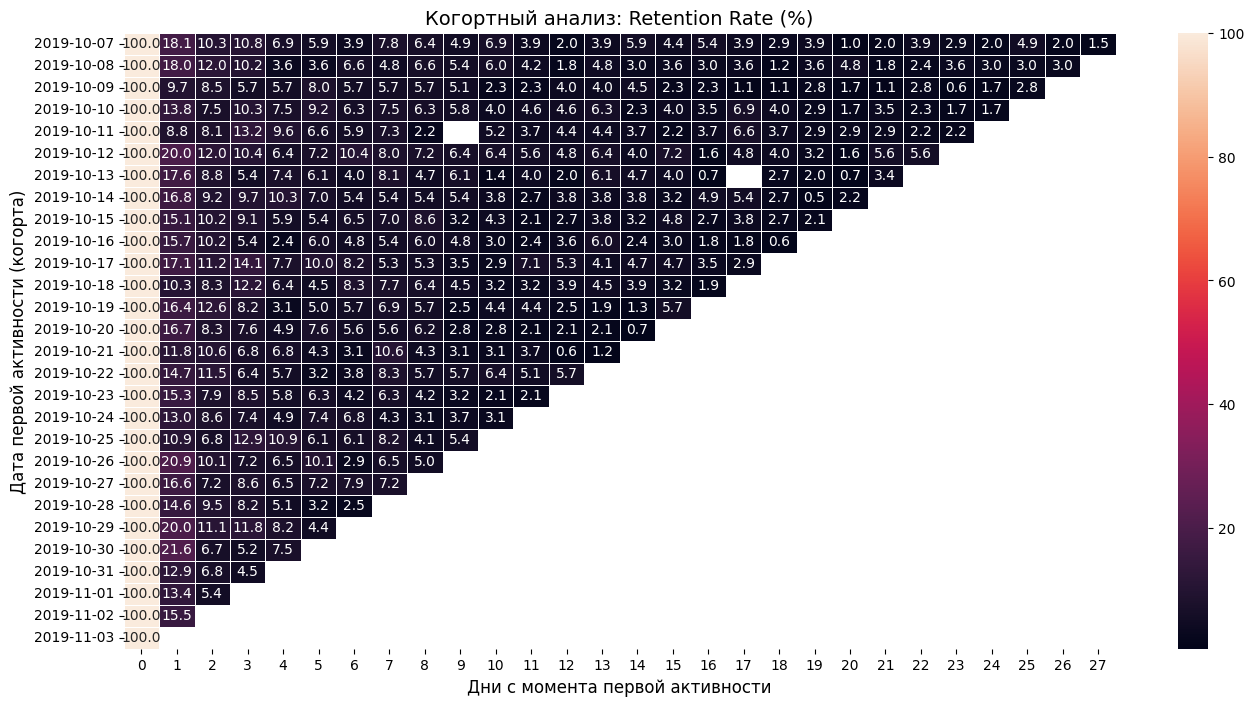

In [ ]:
retention_rate.index = retention_rate.index.astype(str)

#создаем тепловую карту
plt.figure(figsize=(16, 8))
sns.heatmap(retention_rate, annot=True, fmt=".1f", linewidths=0.5)

#заголовки
plt.title("Когортный анализ: Retention Rate (%)", fontsize=14)
plt.yticks(rotation=0)
plt.xlabel("Дни с момента первой активности", fontsize=12)
plt.ylabel("Дата первой активности (когорта)", fontsize=12)

plt.show()

**Выводы по Retention Rate**

1. Сильное падение удержания после первого дня:
В среднем только 10-20% пользователей возвращаются на второй день.
Это стандартное поведение для мобильных приложений, но может указывать на слабую вовлеченность.

2. Низкий Retention после 7 дней
Через неделю остаётся менее 5% пользователей.
Это значит, что большинство пользователей используют приложение 1-2 раза и не возвращаются.
3. Некоторые когорты показывают лучшее удержание: Видны когорты, где Retetion на 7-й день выше среднего.
Можно детальнее изучить, что особенного в этих пользователях (например, откуда они пришли или какие действия совершали).
4. После 14 дней удержание почти нулевое: Почти никто не возвращается спустя две недели.
Это указывает на кратковременный интерес пользователей или отсутствие долгосрочной ценности приложения.

### Время в приложении

Анализ времени, проведенного в приложении, позволит оценить, насколько активно пользователи взаимодействуют с сервисом. Мы разобьем активность пользователей на отдельные сессии, чтобы определить среднюю продолжительность использования и выявить различия между сегментами. Это поможет понять, насколько вовлечены пользователи, какие группы проводят больше времени в приложении и есть ли аномалии в их поведении.

In [ ]:
events_log.head()

,event_time,event_name,user_id,cohort_date,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0


Отсортируем все события для каждого пользователя по времени для корректного формирования сессий:

In [ ]:
#сортируем
data_events = events_log.sort_values(by=['user_id', 'event_time'])

Добавим столбец с разницей во времени между соседними событиями:

In [ ]:
#вычисляем разницу
data_events['time_diff'] = data_events.groupby('user_id')['event_time'].diff()

Зададим промежуток времени между сессиями - 30 минут. Если пользователь не совершал никакиз действий в течение 30 минут и более, значит следующее событие будем считаться новой сессией.

Проставим номера сессии для каждого события:

In [ ]:
#идентифицируем сессии
session_gap = pd.Timedelta(minutes=30)
data_events['new_session'] = data_events['time_diff'] > session_gap

In [ ]:
data_events['session_id'] = data_events.groupby('user_id')['new_session'].cumsum()

In [ ]:
data_events

,event_time,event_name,user_id,cohort_date,lifetime,time_diff,new_session,session_id
805,2019-10-07 13:39:45,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,NaT,False,0
806,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,0 days 00:00:46,False,0
809,2019-10-07 13:41:05,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,0 days 00:00:34,False,0
820,2019-10-07 13:43:20,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,0 days 00:02:15,False,0
830,2019-10-07 13:45:30,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07,0,0 days 00:02:10,False,0
...,...,...,...,...,...,...,...,...
72584,2019-11-03 15:51:23,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12,22,0 days 00:00:27,False,29
72589,2019-11-03 15:51:57,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12,22,0 days 00:00:34,False,29
72684,2019-11-03 16:07:40,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12,22,0 days 00:15:43,False,29
72688,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,2019-10-12,22,0 days 00:00:38,False,29


Теперь рассчитаем время каждой сессии пользователя как разницу между первым и последним событием.

Приведем значения к минутам для удобства понимания:

In [ ]:
#считаем длительность сессии
session_duration = data_events.groupby(['user_id', 'session_id'])['event_time'].agg(['min', 'max']).reset_index()
session_duration['session_length_minutes'] = (session_duration['max'] - session_duration['min']).dt.total_seconds() / 60
session_duration['session_length_minutes'] = session_duration['session_length_minutes'].round(2)

In [ ]:
session_duration

,user_id,session_id,min,max,session_length_minutes
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,0,2019-10-07 13:39:45,2019-10-07 13:49:41,9.93
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-09 18:33:55,2019-10-09 18:42:22,8.45
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-21 19:52:30,2019-10-21 20:07:30,15.00
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-22 11:18:14,2019-10-22 11:30:52,12.63
4,00157779-810c-4498-9e05-a1e9e3cedf93,0,2019-10-19 21:34:33,2019-10-19 21:59:54,25.35
...,...,...,...,...,...
10363,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,25,2019-11-02 01:16:48,2019-11-02 01:16:48,0.00
10364,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,26,2019-11-02 18:01:27,2019-11-02 18:17:41,16.23
10365,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,27,2019-11-02 19:25:53,2019-11-02 19:30:50,4.95
10366,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,28,2019-11-03 14:32:55,2019-11-03 14:48:44,15.82


Сначала рассмотрим основные характеристики длительности сессий, используя метод .describe(), который показывает:

- среднее, медиану (50-й перцентиль),
- минимальное и максимальное значение,
- значения 25-го и 75-го перцентилей (границы основного диапазона значений).

In [ ]:
session_duration['session_length_minutes'].describe()

,session_length_minutes
count,10368.000000
mean,12.877879
std,19.860197
min,0.000000
25%,0.350000
50%,5.580000
75%,17.430000
max,321.980000


Разброс значений по длительности сесссий сильно разнится. Среднее значение превышает медианное почти в два раза, что означает большое количество выбросов.

Вычислим 95-й перцентиль, чтобы понять, какие сессии можно считать редкими и аномально длинными.




In [ ]:
session_duration['session_length_minutes'].quantile(0.95)

48.5265

Отфильтруем таблицу с сессиями для построения гистограммы значений, учитывая, что в данных было обнаружено значительное количество выбросов.

In [ ]:
filtred_session_duration = session_duration[
    session_duration['session_length_minutes'] <= session_duration['session_length_minutes'].quantile(0.95)
]

Построим гистограмму по фильтрованным данным для лучшего понимания визуализации:

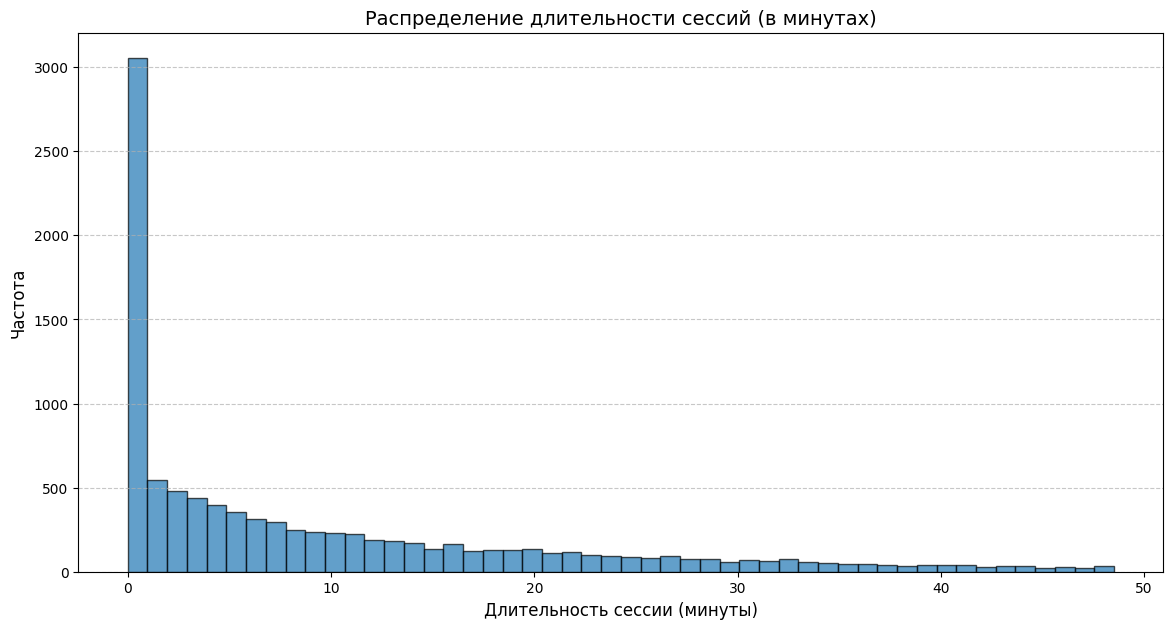

In [ ]:
#сстроим гистограмму длительности сессий
plt.figure(figsize=(14, 7))
plt.hist(filtred_session_duration['session_length_minutes'], bins=50, edgecolor='black', alpha=0.7)

#настройки графика
plt.title("Распределение длительности сессий (в минутах)", fontsize=14)
plt.xlabel("Длительность сессии (минуты)", fontsize=12)
plt.ylabel("Частота", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

**Вывод по анализу длительности сессий:**

1. Большинство пользователей проводят в приложении короткое время: Согласно гистограмме, основная часть сессий длится менее 10 минут.
Это говорит о том, что пользователи заходят в приложение на короткие сеансы, вероятно, чтобы быстро просмотреть объявления. Такое поведение типично для пользователей мобильных приложений.
2. Распределение сильно скошено вправо (асимметричное): Есть небольшое количество длинных сессий, но они встречаются реже.
Медианное значение значительно меньше среднего, что указывает на присутствие длинных сессий-выбросов.
3. Наличие редких длинных сессий: Мы ограничили график 95-м перцентилем, но даже так видно, что некоторые пользователи остаются в приложении 30-60 минут и дольше.
Такие пользователи могут быть более вовлечены в процесс поиска или просто оставляют приложение открытым.

### Частота действий

Анализ частоты действий позволит понять, насколько активно пользователи взаимодействуют с приложением. Мы изучим, как часто совершаются события, есть ли группы пользователей с разной степенью вовлеченности и как это может влиять на удержание и конверсию. Это поможет выявить закономерности в поведении и определить, какие пользователи наиболее ценные для сервиса.

Подсчитаем количество событий на каждого пользователя:

In [ ]:
#группируем данные
event_frequency = events_log.groupby('user_id')['event_name'].count().reset_index()
event_frequency.rename(columns={'event_name': 'total_events'}, inplace=True)
event_frequency

,user_id,total_events
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,35
1,00157779-810c-4498-9e05-a1e9e3cedf93,71
2,00463033-5717-4bf1-91b4-09183923b9df,10
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,32
4,00551e79-152e-4441-9cf7-565d7eb04090,8
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,17
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,7
4290,ffcf50d9-293c-4254-8243-4890b030b238,2
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,13


Просмотрим статистику событий:

In [ ]:
event_frequency.describe()

,total_events
count,4293.000000
mean,17.283252
std,29.130677
min,1.000000
25%,5.000000
50%,9.000000
75%,17.000000
max,478.000000


Судя по данным у нас имеется большое количество выбросов с высоким значением действий. Создадим отфильтрованную таблицу с количество событий, ограничив 95 перцентилем.

In [ ]:
#фильтруем
filtered_event_frequency = event_frequency[
    event_frequency['total_events'] <= event_frequency['total_events'].quantile(0.95)
    ]

Посроим гистограмму распределения количества событий для пользователей:

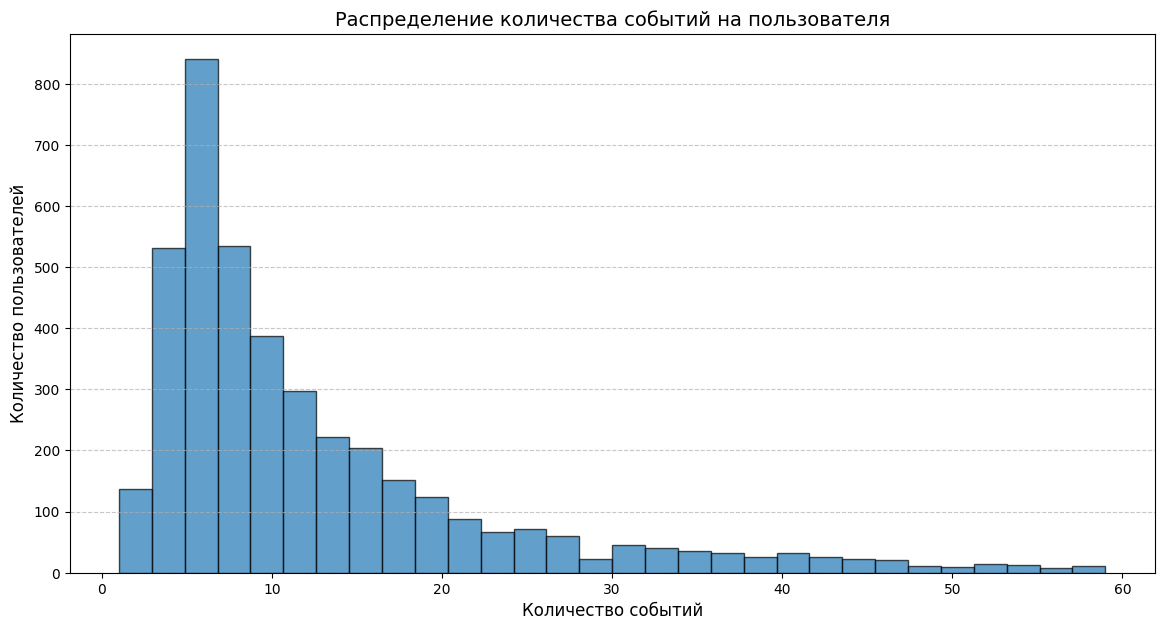

In [ ]:
plt.figure(figsize=(14, 7))

#строим гистограмму количества событий
plt.hist(filtered_event_frequency['total_events'], bins=30, edgecolor='black', alpha=0.7)
plt.title("Распределение количества событий на пользователя", fontsize=14)
plt.xlabel("Количество событий", fontsize=12)
plt.ylabel("Количество пользователей", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Анализ частоты совершения событий пользователями**

Для исследования активности пользователей было рассчитано количество событий, совершенных каждым пользователем за весь период.

Основные статистики частоты событий
- Среднее количество действий на пользователя: 17.3 события.
- Медианное значение: 9 событий, что говорит о том, что половина пользователей совершает менее 9 действий.
- 75% пользователей совершают до 17 событий, но встречаются и пользователи с очень высокой активностью (до 478 событий).
- Чтобы избежать искажения анализа, все значения выше 95-го перцентиля были исключены при построении графика.

Гистограмма распределения частоты событий:

Большинство пользователей совершают до 10-15 действий за всё время использования. Длинный "хвост" распределения указывает на малую долю очень активных пользователей, которые совершают более 50 событий.

Выводы по анализу:

1. Основная масса пользователей использует приложение умеренно, совершая от 5 до 17 событий.
2. Есть небольшая доля очень активных пользователей, но их вклад стоит анализировать отдельно.
3. Возможно, стоит сегментировать пользователей по уровню активности, чтобы выявить различия в их поведении и конверсии.

### Конверсия

Анализ конверсии поможет понять, какая доля пользователей совершает целевое действие — просмотр контактов. Мы изучим, как часто пользователи доходят до этого этапа, и рассмотрим их распределение по дням. Это позволит определить возможные точки роста и оптимизации внутри приложения.

В отдельной переменной запишем общее количество уникальных пользователей:

In [ ]:
total_users = events_log['user_id'].nunique()
total_users

4293

Отдельно найдем количество пользователей, хотя б раз совершивших целевое действие

In [ ]:
final_event = events_log[events_log['event_name'] == 'contacts_show']
final_users = final_event['user_id'].nunique()
final_users

981

Для расчета конверсии разделим целевое количество пользователей на общее количество пользователей и приведеме значение к проценту:

In [ ]:
conversion_rate = (final_users / total_users) * 100
conversion_rate

22.851153039832283

Конверсия в просмотр контактов составляет 22.85%. Это означает, что примерно каждый пятый пользователь совершает целевое действие.

Чтобы лучше понять динамику конверсии, мы построим график количества уникальных пользователей, просмотревших контакты, по дням. Это поможет выявить тренды, возможные скачки или падения активности, а также определить, насколько стабильно пользователи совершают целевое действие в течение анализируемого периода.

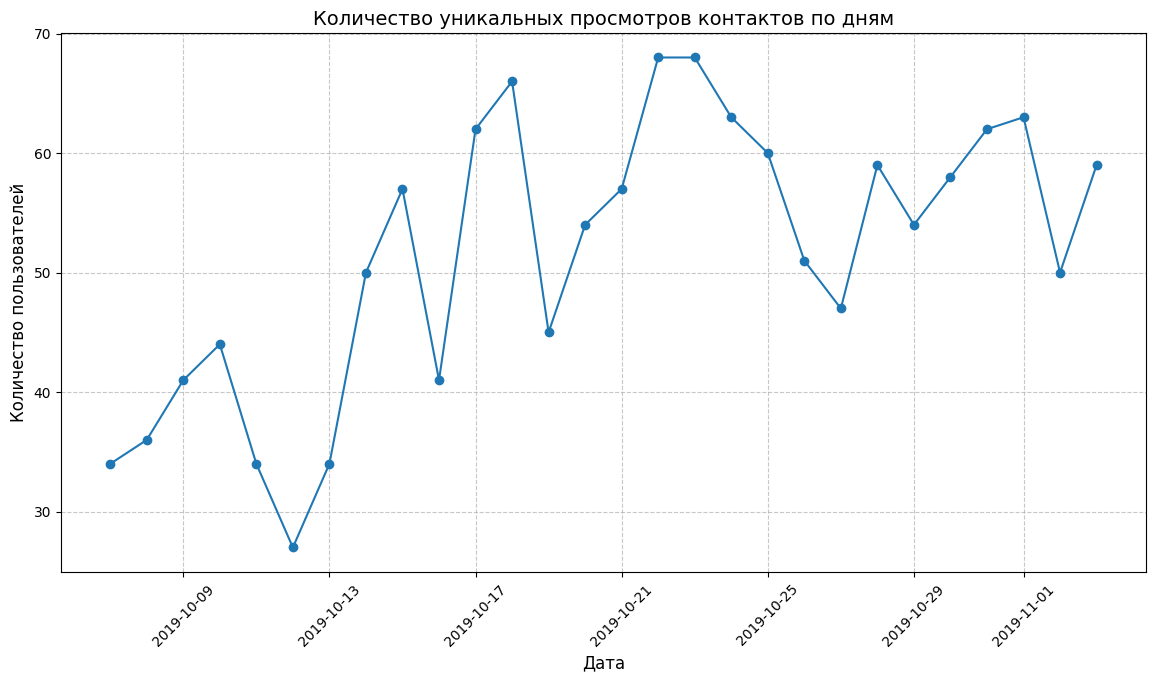

In [ ]:
#группируем по дате и считаем количество уникальных пользователей, совершивших просмотр контактов
contacts_per_day = final_event.groupby(final_event['event_time'].dt.date)['user_id'].nunique()

plt.figure(figsize=(14, 7))
#строим линейный график
plt.plot(contacts_per_day.index, contacts_per_day.values, marker='o', linestyle='-')
plt.title("Количество уникальных просмотров контактов по дням", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Количество пользователей", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

**Анализ конверсии в просмотры контактов**

Основные показатели
- Общее количество уникальных пользователей: 4 293
- Количество пользователей, совершивших просмотр контактов: 981
- Конверсия в просмотры контактов: 22.85%

Динамика просмотров контактов

На графике видно, что количество пользователей, совершающих просмотр контактов, меняется день ото дня.
Есть колебания, но общий тренд не показывает явного резкого роста или падения.
Наиболее активные дни приходятся на середину октября, где количество уникальных пользователей достигает 65-70 человек в день.

Выводы по метрике

1. Примерно 22.85% пользователей доходят до просмотра контактов. Это достаточно высокий показатель, но оставшаяся часть пользователей не выполняет целевое действие.
2. Возможно, стоит исследовать, какие факторы влияют на конверсию – например, просмотр фотографий, рекомендации или другие события.
3. Временная динамика показывает некоторые колебания, но в целом не выявлено сильных всплесков или падений.

## Сегментация

Для более глубокого понимания поведения пользователей мы разделим их на группы по ключевым признакам. Это поможет выявить, какие категории пользователей чаще возвращаются в приложение (удержание) и какие с большей вероятностью совершают целевые действия (конверсия в просмотры контактов).

Мы выбрали два признака для сегментации:

- Общее время, проведенное в приложении — этот показатель отражает вовлеченность пользователя. Логично предположить, что пользователи, которые проводят больше времени, могут быть более заинтересованы.
- Количество сессий — показывает, насколько часто пользователь возвращается в приложение. Те, кто заходит в приложение несколько раз, могут быть более активными и лояльными.

Эти признаки помогут нам разделить пользователей на 4 сегмента и изучить, как они различаются по ключевым метрикам.

Используя уже созданную таблицу с сессиями пользователей, подсчитаем общее количество времени, проведенного пользователем в приложении:

In [ ]:
#суммируем время сессий
user_total_time = session_duration.groupby('user_id')['session_length_minutes'].sum().reset_index()
user_total_time.head()

,user_id,session_length_minutes
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,46.01
1,00157779-810c-4498-9e05-a1e9e3cedf93,196.23
2,00463033-5717-4bf1-91b4-09183923b9df,24.70
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,110.73
4,00551e79-152e-4441-9cf7-565d7eb04090,9.32


Также для каждого пользователя посчитаем количество сессий, начатых им в приложении:

In [ ]:
#считаем количество сессий
user_sessions = session_duration.groupby('user_id')['session_id'].nunique().reset_index()
user_sessions.head()

,user_id,session_id
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,6
2,00463033-5717-4bf1-91b4-09183923b9df,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6
4,00551e79-152e-4441-9cf7-565d7eb04090,3


In [ ]:
#объединяем данные в единый датафрейм
user_segments = user_total_time.merge(user_sessions, on='user_id', how='inner')
user_segments.rename(columns={'session_length_minutes': 'total_time', 'session_id': 'session_count'}, inplace=True)
user_segments

,user_id,total_time,session_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,46.01,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,196.23,6
2,00463033-5717-4bf1-91b4-09183923b9df,24.70,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,110.73,6
4,00551e79-152e-4441-9cf7-565d7eb04090,9.32,3
...,...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,49.41,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,0.88,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,1.33,1
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,38.90,3


Рассмотрим подробнее характеристики полученных значений:

In [ ]:
#смотрим статистику
user_segments.describe()

,total_time,session_count
count,4293.000000,4293.000000
mean,31.101293,2.415094
std,62.763277,3.536466
min,0.000000,1.000000
25%,6.070000,1.000000
50%,15.100000,1.000000
75%,33.300000,3.000000
max,1684.770000,99.000000


Перед сегментацией пользователей мы проанализировали распределение двух ключевых параметров: общего времени, проведенного в приложении (total_time), и количества сессий (session_count).

**Основные показатели:**

Среднее время использования приложения составляет ~31 минуту, но медианное значение 15,1 минуты, что указывает на скошенность распределения и наличие пользователей с очень долгими сессиями.

Среднее количество сессий — 2,41, но медиана — всего 1 сессия. Это значит, что половина пользователей совершает только одну сессию, а оставшиеся — две и более.

In [ ]:
#запишем медианы в отдельные переменные
median_time = user_segments['total_time'].median()
median_sessions = user_segments['session_count'].median()

Из-за особенностей распределения метрик мы решили разделить пользователей на 4 сегмента, используя медианные значения в качестве границы. Это позволяет:

1. Разделить пользователей по интенсивности использования приложения (много или мало времени).
2. Разграничить пользователей, которые совершили только одну сессию или вернулись повторно.

Важно отметить, что медиана количества сессий = 1. Это означает, что большинство пользователей либо заходят только один раз, либо сразу переходят в категорию "многоразовых" посетителей. Если бы медиана была выше, мы могли бы рассмотреть больше градаций, но в данном случае такой подход позволяет выделить две ключевые поведенческие группы: однократные заходы и возвраты.

In [ ]:
#делим на сегменты по медианному значению
user_segments['time_segment'] = user_segments['total_time'].apply(lambda x: 'мало времени' if x <= median_time else 'много времени')
user_segments['session_segment'] = user_segments['session_count'].apply(lambda x: '1 сессия' if x <= median_sessions else 'больше 1 сессии')
user_segments.head(10)

,user_id,total_time,session_count,time_segment,session_segment
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,46.01,4,много времени,больше 1 сессии
1,00157779-810c-4498-9e05-a1e9e3cedf93,196.23,6,много времени,больше 1 сессии
2,00463033-5717-4bf1-91b4-09183923b9df,24.70,1,много времени,1 сессия
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,110.73,6,много времени,больше 1 сессии
4,00551e79-152e-4441-9cf7-565d7eb04090,9.32,3,мало времени,больше 1 сессии
5,00554293-7e00-4122-b898-4e892c4a7c53,7.04,2,мало времени,больше 1 сессии
6,005fbea5-2678-406f-88a6-fbe9787e2268,10.80,1,мало времени,1 сессия
7,00653802-5ff1-4071-bc17-347fc4cef569,8.52,1,мало времени,1 сессия
8,006a32d4-ee10-40dc-b237-11e0fde81cbc,15.70,1,много времени,1 сессия
9,006f6ced-225b-4f9c-9f17-23404bc6835f,9.08,1,мало времени,1 сессия


Такой метод сегментации даст возможность изучить, как различается поведение пользователей в зависимости от времени, проведенного в приложении, и их склонности к возврату. В дальнейшем мы проверим, как различаются ключевые метрики (удержание, конверсия) в разных группах.

Создадим функцию для обозначения выбора сегмента пользователя в зависимости от значения полей time_segment и session_segment:

In [ ]:
def assign_segment(row):
    '''
    Функция для присвоения сегмента пользователю в зависимости от времени и количества сессий.
    '''
    if  row['time_segment'] == 'мало времени' and row['session_segment'] == '1 сессия':
        return 'A: 1 короткая сессия'
    elif row['time_segment'] == 'мало времени' and row['session_segment'] == 'больше 1 сессии':
        return 'B: несколько коротких сессий'
    elif row['time_segment'] == 'много времени' and row['session_segment'] == '1 сессия':
        return 'C: 1 длинная сессия'
    else:
        return 'D: много длинных сессий'



In [ ]:
#применим функцию к каждому пользователю
user_segments['user_group'] = user_segments.apply(assign_segment, axis=1)

#проверим, сколько пользователей в каждом сегменте
user_segments['user_group'].value_counts()

,count
user_group,
A: 1 короткая сессия,1416
D: много длинных сессий,1261
C: 1 длинная сессия,884
B: несколько коротких сессий,732


После разделения пользователей по количеству сессий и времени, проведенному в приложении, мы получили четыре сегмента:
- A: 1 короткая сессия (1416 пользователей) — пользователи, которые зашли в приложение только один раз и провели в нем мало времени.
- B: Несколько коротких сессий (732 пользователя) — пользователи, которые заходили в приложение несколько раз, но в среднем проводили в нем мало времени.
- C: 1 длинная сессия (884 пользователя) — пользователи, которые зашли только один раз, но провели в приложении много времени.
- D: Много длинных сессий (1261 пользователь) — самые активные пользователи, которые заходили в приложение несколько раз и проводили там значительное время.

Такое распределение показывает, что большая часть пользователей либо взаимодействует с приложением однократно и недолго, либо напротив возвращается многократно и проводит там больше времени. Теперь мы можем сравнить эти группы по ключевым метрикам, чтобы понять, какие из них показывают более высокое удержание и конверсию

### Анализ сегментов

После сегментации пользователей важно проверить, как их поведение различается в ключевых метриках. Мы уже анализировали Retention Rate и конверсию в просмотры контактов на общем уровне, но теперь посмотрим, как эти показатели меняются в разных сегментах.

Это поможет нам:

- Определить, какие группы пользователей наиболее лояльны и активны.
- Найти сегменты с низким удержанием и конверсией, которые могут требовать дополнительных мер для повышения вовлеченности.
- Проверить, действительно ли время в приложении и количество сессий влияют на ключевые метрики.

Таким образом, анализ удержания и конверсии в разрезе сегментов поможет нам сделать более точные выводы о поведении пользователей и определить, какие группы приносят наибольшую ценность для продукта.

#### Retention rate в разрезе сегментов

Добавим информацию о сегментах пользователей в первоначальный датасет с событиями:

In [ ]:
#добавляем информацию о группе
events_log = events_log.merge(user_segments[['user_id', 'user_group']], on='user_id', how='left')
events_log.head()

,event_time,event_name,user_id,cohort_date,lifetime,user_group
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,C: 1 длинная сессия
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,C: 1 длинная сессия
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0,D: много длинных сессий
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,2019-10-07,0,C: 1 длинная сессия
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,2019-10-07,0,D: много длинных сессий


Заново сфрмируем когорты пользователей, теперь с разбивкой на выделенные сегменты:

In [ ]:
#группируем по дате первой сессии, дню лайфтайма и сегменту
cohort_counts = events_log.groupby(['cohort_date', 'lifetime', 'user_group'])['user_id'].nunique().reset_index()

#определяем размер когорты
cohort_sizes = cohort_counts[cohort_counts['lifetime'] == 0][['cohort_date', 'user_group', 'user_id']]
cohort_sizes.rename(columns={'user_id': 'cohort_size'}, inplace=True)

#объединяем таблицы, добавляя размер когорты
cohort_counts = cohort_counts.merge(cohort_sizes, on=['cohort_date', 'user_group'])

Для расчета удежания делим количество пользователей в каждый из дней на общее количестов пользователей в когорте:

In [ ]:
#рассчитываем Retention Rate
cohort_counts['retention_rate'] = cohort_counts['user_id'] / cohort_counts['cohort_size'] * 100
cohort_counts

,cohort_date,lifetime,user_group,user_id,cohort_size,retention_rate
0,2019-10-07,0,A: 1 короткая сессия,48,48,100.000000
1,2019-10-07,0,B: несколько коротких сессий,45,45,100.000000
2,2019-10-07,0,C: 1 длинная сессия,40,40,100.000000
3,2019-10-07,0,D: много длинных сессий,71,71,100.000000
4,2019-10-07,1,B: несколько коротких сессий,8,45,17.777778
...,...,...,...,...,...,...
778,2019-11-02,1,D: много длинных сессий,11,16,68.750000
779,2019-11-03,0,A: 1 короткая сессия,60,60,100.000000
780,2019-11-03,0,B: несколько коротких сессий,9,9,100.000000
781,2019-11-03,0,C: 1 длинная сессия,43,43,100.000000


Построим линейный график для визуализации изменения Retention rate для сегментов:

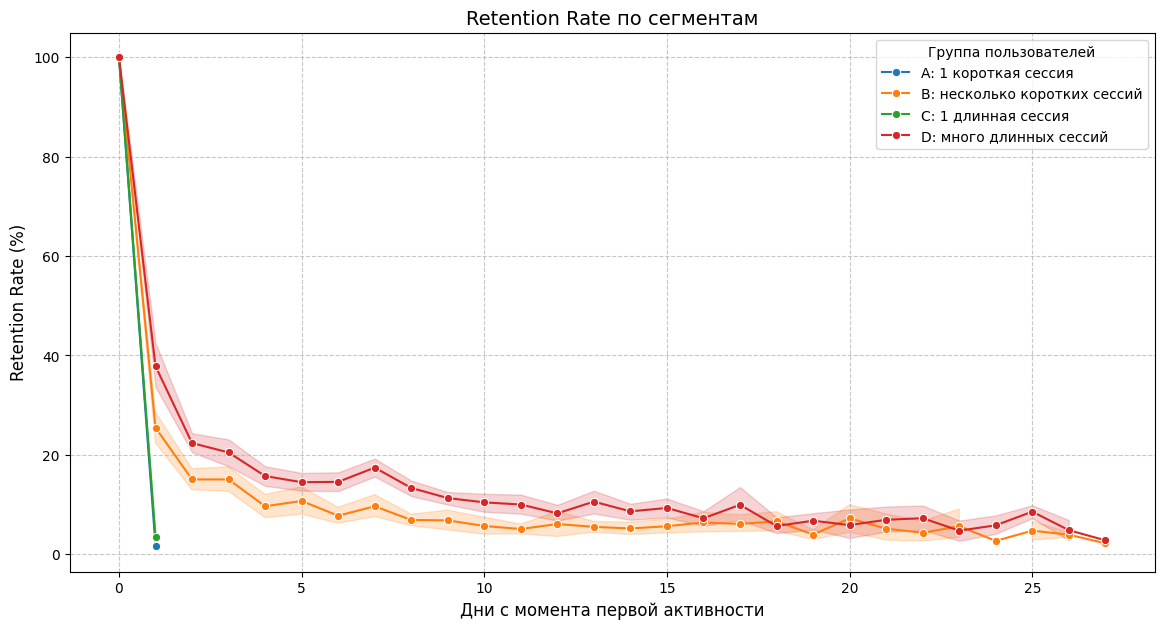

In [ ]:
plt.figure(figsize=(14, 7))
#строим линейный график
sns.lineplot(data=cohort_counts, x='lifetime', y='retention_rate', hue='user_group', marker="o")

plt.title("Retention Rate по сегментам", fontsize=14)
plt.xlabel("Дни с момента первой активности", fontsize=12)
plt.ylabel("Retention Rate (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Группа пользователей")
plt.show()

**Выводы:**

**Общий тренд:** У всех сегментов наблюдается резкое падение удержания после первого дня, что типично для мобильных приложений.

**Лидеры по удержанию:** Пользователи с длинными и множественными сессиями (группа D) удерживаются лучше всех на протяжении всего периода. Это означает, что чем больше времени пользователь проводит в приложении и чем чаще возвращается, тем выше вероятность его долгосрочного удержания.

**Наихудшее удержание:** Группы A (1 короткая сессия) и C (1 длинная сессия) имеют самое низкое удержание. Это пользователи, которые зашли один раз (независимо от времени в приложении) и больше не вернулись.

Группа B (несколько коротких сессий) показывает немного лучшее удержание, чем группы A и C, но все равно существенно уступает группе D. Возможно, такие пользователи заинтересованы, но чего-то им не хватает, чтобы остаться надолго.

**Рекомендации:** Можно попробовать стимулировать возвращение пользователей из групп A, B и C, например, через персонализированные уведомления или улучшенный onboarding, особенно для тех, кто проявил интерес, но не вернулся. Также важно продолжать поддерживать высокий уровень вовлеченности у группы D, так как именно они составляют ядро активных пользователей.

#### Конверсия в разрезе сегментов

Для каждого из выделенных сегментов подсчитаем общее количество пользователей и количество пользователей, совершивших целевой действие:

In [ ]:
#количество уникальных пользователей, совершивших contacts_show, по сегментам
contacts_users = events_log[events_log['event_name'] == 'contacts_show'].groupby('user_group')['user_id'].nunique().reset_index()
contacts_users.rename(columns={'user_id': 'contacts_users'}, inplace=True)

#общее количество уникальных пользователей в каждом сегменте
total_users = user_segments.groupby('user_group')['user_id'].nunique().reset_index()
total_users.rename(columns={'user_id': 'total_users'}, inplace=True)

#объединяем таблицы
conversion_data = total_users.merge(contacts_users, on='user_group', how='left')
conversion_data['contacts_users'] = conversion_data['contacts_users'].fillna(0)  # Если нет значений, заполняем 0

#считаем конверсию
conversion_data['conversion_rate'] = (conversion_data['contacts_users'] / conversion_data['total_users']) * 100
conversion_data

,user_group,total_users,contacts_users,conversion_rate
0,A: 1 короткая сессия,1416,185,13.064972
1,B: несколько коротких сессий,732,181,24.726776
2,C: 1 длинная сессия,884,155,17.533937
3,D: много длинных сессий,1261,460,36.478985


Построим столбчатую диаграмму для лучшей визуализации полученных результато:

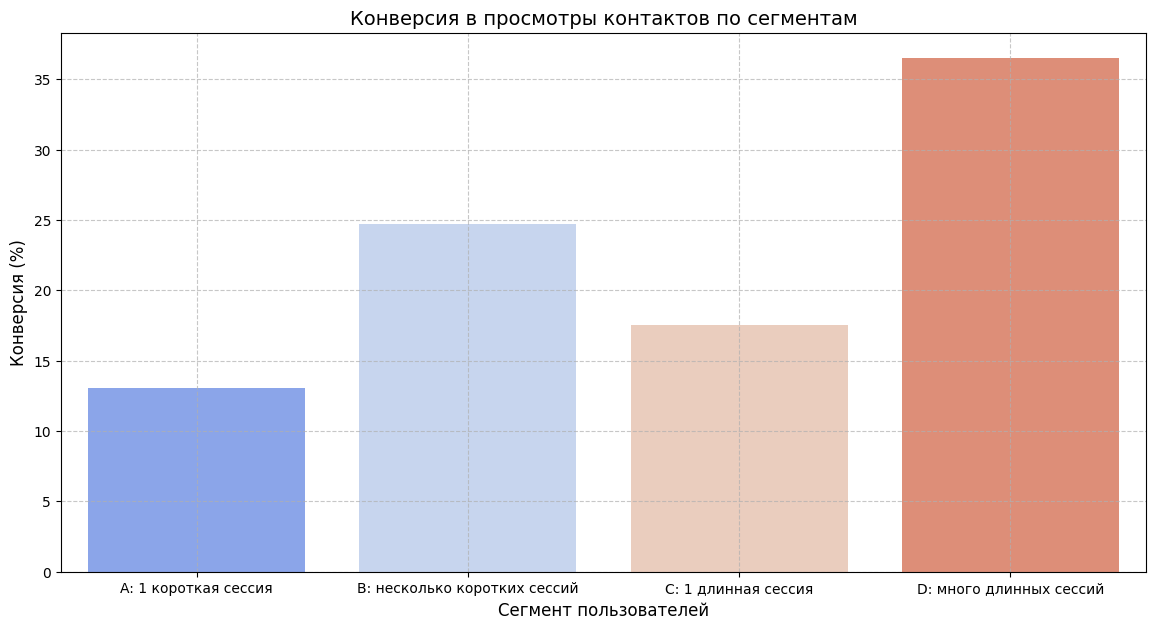

In [ ]:
plt.figure(figsize=(14, 7))
#строим столбчатую диаграмму
sns.barplot(data=conversion_data, x='user_group', y='conversion_rate', palette='coolwarm')

plt.title("Конверсия в просмотры контактов по сегментам", fontsize=14)
plt.xlabel("Сегмент пользователей", fontsize=12)
plt.ylabel("Конверсия (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

**Выводы:**

- Наибольшая конверсия у группы D (много длинных сессий) — более 35%. Это ожидаемо, так как пользователи, которые часто заходят в приложение и проводят там много времени, проявляют больший интерес к контенту и с высокой вероятностью совершают целевое действие.

- Группа B (несколько коротких сессий) показывает вторую по величине конверсию (~25%). Это говорит о том, что даже короткие, но повторяющиеся посещения помогают пользователям дойти до просмотра контактов.

- Группа C (1 длинная сессия) имеет средний уровень конверсии (~17%), что подтверждает, что даже длительное пребывание в приложении не гарантирует выполнение целевого действия. Вероятно, часть таких пользователей изучает приложение, но не находит достаточного повода для взаимодействия.

- Наименьшая конверсия у группы A (1 короткая сессия) — около 13%. Эти пользователи заходят в приложение один раз, быстро его покидают и почти не совершают целевых действий.

**Рекомендации:**

Фокус на группы B и D — они уже вовлечены, можно тестировать персонализированные рекомендации, чтобы еще больше увеличить их конверсию.

Анализ группы C — возможно, этим пользователям чего-то не хватает для принятия решения (не хватает удобных фильтров, информации в карточках и т. д.).

Работа с группой A — можно подумать о более привлекательном первом опыте для новых пользователей, например, изменении onboarding-сценариев или упрощении интерфейса.

### Общий вывод по сегментации:

Мы разделили пользователей на четыре сегмента, учитывая два ключевых параметра:  

- **Общее время в приложении**  
- **Количество сессий**  

Такое разделение позволило выделить группы с разными моделями поведения:  
**A** — 1 короткая сессия  
**B** — Несколько коротких сессий  
**C** — 1 длинная сессия  
**D** — Много длинных сессий  

Эта сегментация дала четкое понимание того, как пользователи взаимодействуют с сервисом.  

**Удержание пользователей (Retention Rate)**  
- Лучше всего удерживаются пользователи из сегмента **D** (*много длинных сессий*). Они продолжают возвращаться в приложение.  
- Хуже всего удерживаются пользователи из сегмента **A** (*1 короткая сессия*). Они почти не возвращаются.  
- Это может указывать на проблемы с вовлечением новых пользователей или недостаточную ценность сервиса для этой группы.  

**Конверсия в просмотры контактов**  
- Выше всего конверсия у самых активных пользователей (*D: много длинных сессий*).  
- Самая низкая конверсия у пользователей, которые зашли всего один раз (*A: 1 короткая сессия*).  
- Это подтверждает связь между активностью и целевыми действиями: чем больше вовлеченность, тем выше вероятность просмотра контактов.  

**Рекомендации**  
Удержание: Улучшить первый опыт пользователей группы A (например, добавить подсказки, вовлекающий контент, улучшенный онбординг.).  
Вовлеченность: Сегменту B (несколько коротких сессий) предложить персонализированные рекомендации и напоминания.  
Монетизация: Группе D (лояльные пользователи) предложить дополнительные функции или программу лояльности.  

Таким образом, сегментация позволила выявить ключевые различия в поведении пользователей и определить направления для повышения удержания, конверсии и вовлеченности.


## Проверка гипотез

В этом разделе мы проверим статистические гипотезы, чтобы понять, действительно ли различия, которые мы наблюдаем в данных, значимы или являются случайными. Гипотезы помогут нам подтвердить или опровергнуть важные закономерности в поведении пользователей.

Основная цель проверки — выявить факторы, влияющие на конверсию, и получить аргументированные выводы, которые могут помочь в принятии решений по улучшению продукта и маркетинговых стратегий.

### Гипотеза 1

В первую очередь мы хотим проверить, различается ли конверсия в просмотры контактов между пользователями, пришедшими из Yandex и Google. Для этого нам нужно сравнить по каждому из источников количество пользователей, которые совершили целевое действие contacts_show с общим количеством.

Сформулируем гипотезы для проверки:


**Нулевая гипотеза (H₀):** Конверсия пользователей из Yandex и Google не отличается.

**Альтернативная гипотеза (H₁):** Конверсия пользователей из Yandex и Google различается.

Проверка этой гипотезы важна, так как если обнаружатся значимые различия, это может повлиять на стратегию маркетинга. Например, можно пересмотреть бюджет на рекламу в одном из каналов.

Для начала посчитаем общее количество пользователей в каждом из источников в датафрейме users_sources:

In [ ]:
#смотрим датафрейм с источниками
users_sources.head()

,user_id,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [ ]:
#считаем общее количество пользователей по источникам
total_users = users_sources.groupby('source')['user_id'].nunique().reset_index()
total_users.rename(columns={'user_id': 'total_users'}, inplace=True)
total_users

,source,total_users
0,google,1129
1,other,1230
2,yandex,1934


Далее нам нужно найти пользователей, которые совершили целевое действие, для этого объединим с датафреймом с событиями и найдем пересечение:

In [ ]:
#находим пользователей, совершившие contacts_show
contacts_users = users_sources.merge(events_log[events_log['event_name'] == 'contacts_show'],
                                     on='user_id', how='inner')

Рассчитываем конверсию целевого действия для каждого из источников пользователей:

In [ ]:
#считаем уникальных пользователей, совершивших contacts_show, по источникам
contacts_counts = contacts_users.groupby('source')['user_id'].nunique().reset_index()
contacts_counts.rename(columns={'user_id': 'contacts_users'}, inplace=True)

#объединяем таблицы
conversion_data = total_users.merge(contacts_counts, on='source', how='left').fillna(0)

#считаем конверсию
conversion_data['conversion_rate'] = conversion_data['contacts_users'] / conversion_data['total_users']
conversion_data

,source,total_users,contacts_users,conversion_rate
0,google,1129,275,0.243578
1,other,1230,228,0.185366
2,yandex,1934,478,0.247156


Для проверки гипотезы о разнице в конверсии между пользователями из Yandex и Google мы используем **z-тест для двух независимых долей**. Этот тест подходит, потому что:

- Мы сравниваем доли успешных событий (конверсию), а не средние значения.
- Размер выборки достаточно большой (в каждой группе более 1000 пользователей), что позволяет применять приближение нормального распределения (по центральной предельной теореме).
- Данные в двух группах независимы – пользователь не может одновременно прийти из двух разных источников.

Таким образом, z-тест корректно определит, есть ли статистически значимые различия в конверсии между группами.

Найдем количество успехов и общего количество испытаний для каждой из групп:

In [ ]:
#количество пользователей в каждой группе
n_yandex = conversion_data[conversion_data['source'] == 'yandex']['total_users'].values[0]
n_google = conversion_data[conversion_data['source'] == 'google']['total_users'].values[0]

In [ ]:
#количество пользователей, совершивших целевое действие
success_yandex = conversion_data.loc[conversion_data['source'] == 'yandex', 'contacts_users'].values[0]
success_google = conversion_data.loc[conversion_data['source'] == 'google', 'contacts_users'].values[0]

Теперь, когда у нас есть данные о количестве пользователей в каждой группе и количестве пользователей, совершивших целевое действие, мы можем провести статистический тест.

Уровень значимости (alpha) установлен на 0.05 – это стандартный порог в статистике. Если p-value окажется меньше 0.05, то мы отвергнем нулевую гипотезу и признаем, что конверсии в Яндексе и Google различаются статистически значимо. Если p-value больше 0.05, значит, у нас нет достаточных оснований утверждать, что конверсии отличаются.

In [ ]:
#данные для теста
counts = np.array([success_yandex, success_google])
nobs = np.array([n_yandex, n_google])

#запускаем тест
stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

print(f"Z-статистика: {stat:.3f}")
print(f"P-value: {p_value:.5f}")

#задаем уровень значимости
alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу → Конверсии в Яндексе и Google различаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу → Нет статистически значимых различий")


Z-статистика: 0.222
P-value: 0.82443
Не получилось отвергнуть нулевую гипотезу → Нет статистически значимых различий


**Вывод:**

**Статистическая значимость:** Полученное p-значение 0.82443 выше уровня значимости 0.05, что *не позволяет отвергнуть нулевую гипотезу*. Это означает, что различия в конверсии между пользователями из Яндекса и Google статистически незначимы.

**Разница в конверсии:**

- Конверсия пользователей из Яндекса составила 24.72%, а из Google — 24.36%.
- Разница между группами минимальна (0.3 п.п.), и статистический тест показывает, что она могла возникнуть случайно.
- Источник "другое" показал самую низкую конверсию – 18.54%, что уже может быть поводом для отдельного анализа.

**Что это значит:**

- Пользователи из Яндекса и Google ведут себя одинаково в плане конверсии. Различий в эффективности этих источников нет.
- Нет причин отдавать предпочтение одному из них только на основании конверсии – если есть разница в стоимости привлечения, её стоит учитывать отдельно.
- Источник "другое" может быть менее качественным с точки зрения привлечения пользователей, так как его конверсия ниже.

**Итог:**

Конверсии пользователей из Яндекса и Google статистически не различаются, что означает, что выбор между ними следует делать на основе стоимости привлечения, а не на основе эффективности конверсии.


### Гипотеза 2

Сейчас мы проверим, влияет ли взаимодействие с рекомендациями (tips_show и tips_click) на конверсию пользователей в просмотры контактов. Для этого сформулируем следуюшие гипотезы:

**Нулевая гипотеза (H₀):** Конверсия пользователей, взаимодействовавших с рекомендациями, не отличается от конверсии тех, кто с ними не взаимодействовал.

**Альтернативная гипотеза (H₁):** Конверсии этих двух групп различаются.

Если конверсия пользователей, которые видели рекомендации, окажется выше, это может свидетельствовать о положительном эффекте рекомендаций на вовлеченность пользователей. Если же разница окажется незначительной или рекомендации негативно влияют на конверсию, это будет поводом пересмотреть их механику.



Сначала определим пользователей, которые взаимодействовали с рекомендациями (видели или кликали на них), и посчитаем их количество. Затем разделим оставшихся пользователей в отдельную группу, чтобы сравнить численность обеих категорий перед анализом:

In [ ]:
#фильтруем пользователей, которые видели или кликали на рекомендации
recommendation_users = events_log[
    (events_log['event_name'] == 'tips_show') | (events_log['event_name'] == 'tips_click')
]['user_id'].unique()

In [ ]:
#группа 1: пользователи, которые взаимодействовали с рекомендациями
group_1 = pd.DataFrame({'user_id': recommendation_users})
group_1['group'] = 'recommendation'

In [ ]:
#группа 2: пользователи, которые НЕ взаимодействовали с рекомендациями
group_2 = pd.DataFrame({'user_id': events_log[~events_log['user_id'].isin(recommendation_users)]['user_id'].unique()})
group_2['group'] = 'no_recommendation'

#объединяем группы в один датафрейм
users_groups = pd.concat([group_1, group_2])
users_groups['group'].value_counts()

,count
group,
recommendation,2826
no_recommendation,1467


В каждой из групп получилось достаточное количество пользователей для анализа.

Далее для каждого из уникальных пользователей узнаем, совершал ли он целевое действие - просмотр контактов:

In [ ]:
#добавляем информацию о том, кто совершил contacts_show
contacts_users = events_log[events_log['event_name'] == 'contacts_show']['user_id'].unique()

#добавляем колонку, совершал ли пользователь целевое действие
users_groups['contacts_show'] = users_groups['user_id'].isin(contacts_users).astype(int)

users_groups.head()

,user_id,group,contacts_show
0,020292ab-89bc-4156-9acf-68bc2783f894,recommendation,0
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,recommendation,0
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,recommendation,1
3,f32e1e2a-3027-4693-b793-b7b3ff274439,recommendation,0
4,17f6b2db-2964-4d11-89d8-7e38d2cb4750,recommendation,1


Наконец посчитаем конверсию перехода в целевое действие:

In [ ]:
#группируем и считаем конверсию
conversion_data = users_groups.groupby('group', as_index=False).agg(
    total_users=('user_id', 'count'),
    contacts_users=('contacts_show', 'sum')
)
conversion_data['conversion_rate'] = conversion_data['contacts_users'] / conversion_data['total_users']
conversion_data

,group,total_users,contacts_users,conversion_rate
0,no_recommendation,1467,456,0.310838
1,recommendation,2826,525,0.185775


Рассчитанные значения показывают, что:

1. Пользователи без взаимодействия с рекомендациями (no_recommendation) имели конверсию 31.08%.
2. Пользователи, которые видели или кликали на рекомендации (recommendation), показывают 18.58%.

На первый взгляд, разница в конверсии между группами заметна. Однако, прежде чем делать выводы, необходимо убедиться, что разница статистически значима и не является случайной.

Так как мы сравниваем доли пользователей, совершивших целевое действие (contacts_show), между двумя независимыми группами, оптимальным методом будет **Z-тест для пропорций**.

Z-тест подходит, потому что:
- Выборки независимы (пользователь либо взаимодействовал с рекомендациями, либо нет).
- Данные представляют собой доли (пропорции), что соответствует применению z-критерия.
- Число наблюдений достаточно велико для применения нормального приближения (в обеих группах более 1000 пользователей).

Найдем количество успехов и общего количество испытаний для каждой из групп:

In [ ]:
#количество пользователей в каждой группе
n_recommendation = conversion_data.loc[conversion_data['group'] == 'recommendation', 'total_users'].values[0]
n_no_recommendation = conversion_data.loc[conversion_data['group'] == 'no_recommendation', 'total_users'].values[0]

In [ ]:
#количество пользователей, совершивших целевое действие
success_recommendation = conversion_data.loc[conversion_data['group'] == 'recommendation', 'contacts_users'].values[0]
success_no_recommendation = conversion_data.loc[conversion_data['group'] == 'no_recommendation', 'contacts_users'].values[0]

Теперь, когда у нас есть данные о количестве пользователей в каждой группе и числе пользователей, совершивших целевое действие, мы можем проверить статистическую значимость различий.

Уровень значимости (alpha) установлен на 0.05 – это стандартный порог для проверки гипотез. Если p-value окажется меньше 0.05, мы отвергнем нулевую гипотезу и признаем, что конверсии между пользователями, взаимодействовавшими с рекомендациями, и теми, кто с ними не взаимодействовал, статистически значимо различаются. Если p-value окажется больше 0.05, значит, у нас нет достаточных оснований утверждать, что между группами есть разница.

In [ ]:
#данные для теста
counts = np.array([success_recommendation, success_no_recommendation])
nobs = np.array([n_recommendation, n_no_recommendation])

#запуск Z-теста
stat, p_value = proportions_ztest(counts, nobs, alternative='two-sided')

print(f"Z-статистика: {stat:.3f}")
print(f"P-value: {p_value:.5f}")

#задаем уровень значимости
alpha = 0.05

if p_value < alpha:
    print("Отвергаем нулевую гипотезу → Конверсии в группах действительно различаются")
else:
    print("Не удалось отвергнуть нулевую гипотезу → Нет статистически значимых различий")

Z-статистика: -9.256
P-value: 0.00000
Отвергаем нулевую гипотезу → Конверсии в группах действительно различаются


**Вывод:**

**Статистическая значимость:** Полученное p-значение 0.00000 значительно ниже уровня значимости 0.05, что позволяет *отвергнуть нулевую гипотезу*. Это означает, что конверсии в просмотры контактов среди пользователей, взаимодействовавших с рекомендациями, и пользователей, которые с ними не взаимодействовали, действительно различаются.

**Разница в конверсии:**

- Пользователи, которые не взаимодействовали с рекомендациями, показали конверсию 31.1%.
- Пользователи, которые видели или кликали на рекомендации, показали конверсию 18.6%.
- Разница составила более 12 процентных пунктов, что является значительным отклонением.

**Что это значит:**

1. Рекомендации могут отвлекать пользователей от просмотров контактов. Те, кто видел или кликал на рекомендованные объявления, реже доходят до контактов.
2. Пользователи без взаимодействия с рекомендациями показывают лучшую конверсию, что может указывать на то, что стандартный путь поиска объявлений работает эффективнее.
3. Неожиданный результат: Ожидалось, что рекомендации должны повышать вовлеченность, но в данном случае они снижают конверсию в просмотры контактов.

**Итог:**

Взаимодействие с рекомендациями связано с более низкой конверсией в просмотры контактов, и этот эффект статистически значим. Это указывает на возможные проблемы в логике рекомендаций или их влияние на пользовательский сценарий.

## Общий вывод

В ходе исследования были изучены данные о поведении пользователей мобильного приложения "Ненужные вещи и проведен ряд аналитических этапов, позволяющих выявить закономерности и ключевые факторы, влияющие на вовлеченность и конверсию.

**Предобработка данных**

На первом этапе были загружены и очищены данные: приведены столбцы к корректным типам, проведена проверка на дубликаты и пропущенные значения, исправлены неявные дубликаты в названиях событий. Дополнительно были изучены временные рамки данных и проверено количество уникальных пользователей.

**Исследовательский анализ поведения пользователей**

Были изучены ключевые метрики:

- Retention Rate – показал, что большинство пользователей покидает приложение после первого дня использования, что указывает на сложности с удержанием аудитории.
- Время в приложении – значительная часть пользователей проводит в приложении мало времени, но есть группа активных пользователей с длинными сессиями.
- Частота действий – большинство пользователей совершают небольшое количество действий за сессию, но есть активные сегменты с высокой частотой взаимодействий.
- Конверсия в просмотры контактов – составила 22.85%, что означает, что целевое действие совершает примерно каждый пятый пользователь.

**Сегментация пользователей**
Для более детального анализа поведения была проведена сегментация по двум признакам: длительность сессий и количество сессий. В результате выделены 4 группы:

* A: 1 короткая сессия
* B: Несколько коротких сессий
* C: 1 длинная сессия
* D: Много длинных сессий

Анализ метрик в разрезе сегментов позволил выявить значимые различия в удержании и конверсии.

**Анализ удержания и конверсии по сегментам**
- Retention Rate ожидаемо оказался ниже у пользователей с короткими сессиями (группы A и B), а выше – у пользователей с длинными сессиями (C и D).
- Конверсия оказалась самой высокой у группы D (пользователи с множеством длинных сессий), что подтверждает гипотезу о более высокой вовлеченности активных пользователей.

**Проверка гипотез**
1. Различие конверсии между пользователями из Yandex и Google

Тест показал, что статистически значимых различий в конверсии между этими группами нет. Это означает, что источник установки приложения не влияет на вероятность совершения целевого действия.
2. Влияние взаимодействия с рекомендациями на конверсию

Выявлено значимое различие: пользователи, которые взаимодействовали с рекомендациями, имели существенно более низкую конверсию в просмотр контактов (18.6% против 31%). Этот результат требует дополнительного анализа и может говорить о проблемах с рекомендационной системой.

**Основные выводы и рекомендации**
1. Удержание пользователей остается низким, особенно в первых днях. Для его повышения стоит сосредоточиться на первых сессиях и разработке механик вовлечения.
2. Конверсия в целевое действие выше у активных пользователей, что подчеркивает важность механик, стимулирующих повторные визиты и продолжительные сессии.
3. Сегментация выявила ключевые группы пользователей, и подход к каждой из них должен отличаться. Например, короткие сессии требуют удерживающих механик, а лояльные пользователи могут быть вовлечены через персонализированные предложения.
4. Гипотеза о разнице в конверсии между источниками не подтвердилась, поэтому маркетинговые бюджеты можно распределять без приоритета между Yandex и Google.
5. Гипотеза о рекомендациях выявила неожиданный эффект, требующий дополнительного анализа – возможно, пользователи получают нерелевантные рекомендации или теряют интерес после их просмотра.

Итогом исследования стало детальное понимание пользовательского поведения, выявление сильных и слабых сторон продукта, а также постановка новых вопросов, которые могут быть полезны для дальнейших итераций анализа и оптимизации продукта.